In [1]:
from random import choices, randint, randrange, random
from typing import List, Optional, Callable, Tuple
import numpy as np
import sobol_seq
import matplotlib.pyplot as plt
from functools import partial

Genome = List[int]
Population = List[Genome]
FitnessFunc = Callable[[Genome], float]
PopulateFunc = Callable[[], Population]
SelectionFunc = Callable[[Population, FitnessFunc], Tuple[Genome, Genome]]
CrossoverFunc = Callable[[Genome, Genome], Tuple[Genome, Genome]]
MutationFunc = Callable[[Genome], Genome]
PrinterFunc = Callable[[Population, int, FitnessFunc], None]


"""GENERATE POINTS USING SOBOL SEQUENCE"""
def generate_points(dim,npoint,low=-10,high=10):
    if type(low) != type(high):
        raise TypeError('The type of "low" and "high" should be the same.')
    if type(low) == int:
        boundaries = [(low,high) for _ in range (dim)]
    elif type(low) == list or type(low) == np.ndarray:
        if len(low) != len(high):
            raise TypeError('The length of "low" and "high" should be the same.')
        else:
            boundaries = [(low[i],high[i]) for i in range (len(low))]

    # Generate Sobol sequence points
    sobol_points = sobol_seq.i4_sobol_generate(dim, npoint)

    # Scale the Sobol points to fit within the specified boundaries
    scaled_points = []
    for i in range(dim):
        a, b = boundaries[i]
        scaled_dim = a + sobol_points[:, i] * (b - a)
        scaled_points.append(scaled_dim)

    # Transpose the scaled points to get points per dimension
    scaled_points = np.array(list(map(list, zip(*scaled_points))))
    return scaled_points 

def encode_number(number, min_value=-10, max_value=10, num_bits=32):
    # Normalize the number to a value between 0 and 1
    normalized = (number - min_value) / (max_value - min_value)
    # Convert it to an integer representation
    int_representation = int(normalized * (2**num_bits - 1))
    # Convert the integer to binary and pad with zeros
    return [int(x) for x in format(int_representation, '0{}b'.format(num_bits))]

def decode_number(genome:Genome, min_value=-10, max_value=10, num_bits=32):
    # Convert the binary string to an integer
    int_representation = int(''.join(map(str, genome)), 2)
    # Scale down to the normalized value
    normalized = int_representation / (2**num_bits - 1)
    # Denormalize to get the real number
    return min_value + normalized * (max_value - min_value)

def encode_list(number_list,min_value=-10, max_value=10, num_bits=32):
    encoded = []
    for number in number_list:
        encoded += encode_number(number,min_value, max_value, num_bits)
    return encoded

def decode_list(encoded_list,min_value=-10, max_value=10, num_bits=32):
    numbers = []
    for i in range(0, len(encoded_list), num_bits):
        binary_list = encoded_list[i:i + num_bits]
        number = decode_number(binary_list, min_value, max_value, num_bits)
        numbers.append(number)
    return numbers

def generate_population(set_of_points:np.ndarray,min_value=-10, max_value=10, num_bits=32) -> Population:
    return [encode_list(set_of_points[point],min_value, max_value, num_bits) for point in range(len(set_of_points))]

def single_point_crossover(a: Genome, b: Genome, seed, print_cutoff=False) -> Tuple[Genome, Genome]:
    np.random.seed(seed)
    if len(a) != len(b):
        raise ValueError("Genomes a and b must be of same length")
    length = len(a)
    # if the length less than 2, then there is no point to do the function
    if length < 2:  
        return a, b
    # generate random number as the cutoff of the crossover
    p = randint(1, length - 1)
    if print_cutoff == True:
        print(p)
    
    return a[0:p] + b[p:], b[0:p] + a[p:]

def mutation(genome: Genome,probability, seed, num: int = 1) -> Genome:
    np.random.seed(seed)
    # num: generate how many chromosome(s) that we want to mutate
    for _ in range(num):
        # index sets which chromosome we want to change
        index = randrange(len(genome))
        # the change algorithm
        genome[index] = genome[index] if random() > probability else abs(genome[index] - 1)
    return genome

def fitness_function(genome: Genome,objective_function, min_value=-10, max_value=10, num_bits=64) -> float:
    X = decode_list(genome, min_value, max_value, num_bits)
    return objective_function(X)

# for convenience, call fitness function from these functions below using partial(...)
def population_fitness(population: Population, fitness_func: FitnessFunc) -> float:
    return sum([fitness_func(genome) for genome in population])

def selection_pair(population: Population,population_fitness_func, fitness_func: FitnessFunc) -> Population:
    total_sum = population_fitness_func(population,fitness_func)
    return choices(
        population=population,
        weights=[(total_sum-fitness_func(gene))/total_sum for gene in population],
        k=2
    )
def sort_population(population: Population, fitness_func: FitnessFunc) -> Population:
    return sorted(population,key= lambda x: fitness_func(x), reverse=False)

def genome_to_string(genome: Genome) -> str:
    return "".join(map(str, genome))

def print_stats(population: Population, generation_id: int, fitness_func: FitnessFunc, decode_list_func,binary_mode=False):
    print("GENERATION %02d" % generation_id)
    print("=============")
    if binary_mode == True:
        # print("Population: [%s]" % ", ".join([genome_to_string(gene) for gene in population]))
        # print("Avg. Fitness: %f" % (population_fitness(population, fitness_func) / len(population)))
        # print("Worst solution: %s (%f)" % (genome_to_string(population[-1]),
        #                         fitness_func(population[-1])))
        print(
            "Best solution: %s (%f)" % (genome_to_string(population[0]), fitness_func(population[0])))
        print("")
    else:
        # print(f"Population: {[decode_list_func(population[i]) for i in range (len(population))]}")
        # print("Avg. Fitness: %f" % (population_fitness(population, fitness_func) / len(population)))
        # print(f"Worst solution: {(decode_list_func(population[-1]))} with value {fitness_func(population[-1])}")
        print(f"Best solution: {(decode_list_func(population[0]))} with value {fitness_func(population[0])}")
        print("")
    # return sorted_population[0]

def run_evolution(
        objective_function,
        boundaries,
        population_size:int,
        generation_limit:int,
        p_mutation,
        num_bits,
        fitness_limit: int,
        seed: int = 0,
        returning = ['encoded_population','decoded_population', 'best_solution'],
        verbose = False) \
        -> Tuple[Population, int]:
    np.random.seed(seed)
    min_value, max_value = boundaries.min(),boundaries.max()
    dim = boundaries.shape[0]

    iter_points = generate_points(dim,
                                  population_size,
                                  boundaries[:,0],
                                  boundaries[:,1])
    population = generate_population(set_of_points=iter_points,
                                     num_bits=num_bits,
                                     min_value=min_value,
                                     max_value=max_value)

    for i in range(generation_limit):
        # print(f"i={i}")
        population = sort_population(population=population,
                                     fitness_func=partial(
                                         fitness_function,
                                         objective_function=objective_function,
                                         num_bits=num_bits,
                                         min_value=min_value,
                                         max_value=max_value))

        if verbose == True:
            print_stats(population=population,
                        generation_id=i,
                        fitness_func=partial(
                            fitness_function,
                            objective_function=objective_function,
                            max_value=max_value,
                            min_value=min_value,
                            num_bits=num_bits),
                        decode_list_func=partial(
                            decode_list,
                            min_value=min_value,
                            max_value=max_value,
                            num_bits=num_bits)
                        )

        cutoff_criteria = fitness_function(genome = population[0],
                                           objective_function = objective_function, 
                                           min_value=min_value, 
                                           max_value=max_value, 
                                           num_bits=num_bits)
        # print(f"cutoff:{cutoff_criteria}\n")
        # print(decode_list(population[0],min_value=min_value,max_value=max_value,num_bits=64))
        if cutoff_criteria < fitness_limit:
            break

        next_generation = population[0:2]

        for j in range(int(len(population) / 2) - 1):
            parents = selection_pair(population=population,
                                     population_fitness_func=population_fitness,
                                     fitness_func=partial(
                                         fitness_function,
                                         objective_function=objective_function,
                                         max_value=max_value,
                                         min_value=min_value,
                                         num_bits=num_bits))
            # print(f"j={j}")
            # print(decode_list(parents[0],min_value=min_value,max_value=max_value,num_bits=64),decode_list(parents[1],min_value=min_value,max_value=max_value,num_bits=64))
            offspring_a, offspring_b = single_point_crossover(a=parents[0],
                                                              b=parents[1],
                                                              seed=seed)
            offspring_a = mutation(genome=offspring_a,
                                   probability=p_mutation,
                                   seed= seed)
            offspring_b = mutation(genome=offspring_b,
                                   probability=p_mutation,
                                   seed= seed)
            next_generation += [offspring_a, offspring_b]

        population = next_generation
    if returning == 'encoded_population':
        return population, i
    elif returning == 'decoded_population':
        decoded_population = [decode_list(xi, min_value, max_value, num_bits) for xi in population]
        return decoded_population
    else:
        best_solution=decode_list(population[0],
                           min_value=min_value,
                           max_value=max_value,
                           num_bits=num_bits)
        best_value = fitness_function(genome=population[0],
                                      objective_function=objective_function,
                                      min_value=min_value,
                                      max_value=max_value,
                                      num_bits=num_bits)
        return best_solution, best_value


In [2]:
from random import choices, randint, randrange, random,seed
from typing import List, Optional, Callable, Tuple
import numpy as np
import pandas as pd
import sobol_seq
import matplotlib.pyplot as plt
from functools import partial

n_point = 100
k_max = 100
dim = 2
epsilon = 10**(-5)
p_mutation = 0.1
num_bits = 64  # Number of bits for each number
seed = 10

def objective_function(x):
    F = (x[0]-3)**2 + (x[1]-2)**2
    return F

boundaries = np.array([(-10,10) for _ in range (dim)])

run_evolution(objective_function=objective_function,
              boundaries=boundaries,
              population_size=n_point,
              generation_limit=k_max,
              p_mutation=p_mutation,
              num_bits=num_bits,
              fitness_limit=-1+epsilon,
              seed=seed,
              returning='best_solution',
              verbose=True)

GENERATION 00
Best solution: [2.34375, 2.34375] with value 0.548828125

GENERATION 01
Best solution: [2.34375, 2.34375] with value 0.548828125

GENERATION 02
Best solution: [2.34375, 2.34375] with value 0.548828125

GENERATION 03
Best solution: [2.34375, 2.34375] with value 0.548828125

GENERATION 04
Best solution: [2.34375, 1.875004768371582] with value 0.44628787042984186

GENERATION 05
Best solution: [2.34375, 1.875004768371582] with value 0.44628787042984186

GENERATION 06
Best solution: [3.125, 2.34375] with value 0.1337890625

GENERATION 07
Best solution: [3.125, 2.34375] with value 0.1337890625

GENERATION 08
Best solution: [3.125, 2.34375] with value 0.1337890625

GENERATION 09
Best solution: [3.125, 2.34375] with value 0.1337890625

GENERATION 10
Best solution: [3.125, 2.34375] with value 0.1337890625

GENERATION 11
Best solution: [3.125, 2.34375] with value 0.1337890625

GENERATION 12
Best solution: [3.125, 2.34375] with value 0.1337890625

GENERATION 13
Best solution: [3.125

([2.9980707262075246, 2.03125], 0.0009802845973663325)

In [3]:
import numpy as np
from itertools import product,combinations
import matplotlib.pyplot as plt
from typing import Callable,Tuple
from numpy.typing import NDArray
from functools import partial
from tqdm import tqdm

ObjectiveFunctionType = Callable[[np.ndarray], np.ndarray]
BoundariesType = NDArray[np.int_]

def root_objective_function(x,objective_function:ObjectiveFunctionType):
    F_array = objective_function(x)
    denom = 0
    for f in F_array:
        denom +=np.abs(f)
    F = 1/(1+denom)
    return -F

def slice_hypercube(lower_bounds, upper_bounds, interval, dim):
    # Create a list of arrays, each containing points spaced h apart for each dimension
    points = [np.arange(lower_bounds[i], upper_bounds[i], interval) for i in range(dim)]
    
    # Use meshgrid to create a grid of points in n-dimensional space
    grids = np.meshgrid(*points, indexing='ij')
    
    # Flatten and combine the grid points into a single 2D array
    grid_points = np.vstack([grid.ravel() for grid in grids]).T
    
    # Generate all vertices for smaller hypercubes within each grid cell
    return np.array([grid_points + offset for offset in product([0, interval], repeat=dim)])

def root_GenAl(objective_function:ObjectiveFunctionType,
               boundaries: BoundariesType,
               gen_max:int,
               n_points:int,
               epsilon = 10**(-3),
               num_bits:int=64,
               delta = 0.01,
               p_mutation:float=0.1,
               parts:int=100,
               seed:int=0,
               print_cluster=False
               ):
    # length of each parts in each dimension
    inc_int = (boundaries[0,1]-boundaries[0,0])/parts
    dim = boundaries.shape[0]

    # Hypercubes
    hypercubes_edges = slice_hypercube(lower_bounds=boundaries[:,0],
                        upper_bounds=boundaries[:,1],
                        interval=inc_int,
                        dim=dim)
    
    """Clustering Technique"""
    cluster = []
    for hypercube_id in range(hypercubes_edges.shape[1]):
        X0 = hypercubes_edges[:,hypercube_id,:]
        F_list = objective_function(X0.T)

        # cek jika f yang berubah tanda dari F_list jika dievaluasi di tiap edge hypercube
        product_combination = np.array([[a*b for a,b in combinations(F_list[i],2)] for i in range (F_list.shape[0])])

        # jika semua f dari F_list berubah tanda jika dievaluasi di tiap edge hypercube, maka ada akar di situ
        change_sign = np.array([np.any(product_combination[i]<0) for i in range (product_combination.shape[0])])
        if np.all(change_sign==True):
            # print(f'Ada akar di sini: \nX0={X0}')
            cluster.append(X0)
    cluster = np.array(cluster)
    print(f'Roots found in {len(cluster)} hypercubes.')

    """Genetic Algorithm"""
    # GA parameter
    roots = []
    values = []
    for i in tqdm(range(cluster.shape[0]), desc="Processing"):
        cluster_boundaries = np.array([cluster[i,:,:][0],cluster[i,:,:][-1]])
        # cek klo ternyata ada yang ga membentuk boundary
        if np.any(cluster_boundaries[:,0] == cluster_boundaries[:,1]):
            continue
        root,value = run_evolution(objective_function=partial(root_objective_function,objective_function=objective_function),
                                    boundaries=cluster_boundaries,
                                    population_size=n_points,
                                    generation_limit=gen_max,
                                    p_mutation=p_mutation,
                                    num_bits=num_bits,
                                    fitness_limit=epsilon,
                                    seed=seed,
                                    returning='best_solution',
                                    verbose=False)
        # print(cluster_boundaries)
        # print(root)
        roots.append(root)
        values.append(value)
    roots = np.array(roots)
    values = np.array(values)
    if print_cluster==True:
        print(f'Number of Clusters containing root: {cluster.shape[0]}\n')
        print(f'Roots:\n{roots}\n\nValues: \n{values}')

    """Choosing Best Solution"""
    if dim == 1:
        list_criteria = [element for sublist in roots for element in sublist] #convert from 2D array into 1D array
    else:
        list_criteria = roots
    eligible_roots = np.array([x for x in list_criteria if (1-root_objective_function(x,objective_function=objective_function))<epsilon])
    duplicated_roots = []
    for i in range(len(eligible_roots)):
        for j in range (i+1,len(eligible_roots)):
            if np.linalg.norm(eligible_roots[i]-eligible_roots[j])<delta:
                duplicated_roots.append([eligible_roots[i],eligible_roots[j]])
    duplicated_roots = np.unique(duplicated_roots,axis=0)

    deselected_duplicated_roots = []
    for i in range (len(duplicated_roots)):
        value_root_a = root_objective_function(duplicated_roots[i][0],objective_function=objective_function)
        value_root_b = root_objective_function(duplicated_roots[i][1],objective_function=objective_function)
        if dim == 1:
            if value_root_a>value_root_b:
                duplicated_root = duplicated_roots[i][1]
            else:
                duplicated_root = duplicated_roots[i][0]
        else:
            if value_root_a>value_root_b:
                duplicated_root = list(duplicated_roots[i][1])
            else:
                duplicated_root = list(duplicated_roots[i][0])
        deselected_duplicated_roots.append(duplicated_root)

    if dim == 1:
        # Reshape the 1D array to have one column
        deselected_duplicated_roots = np.array(deselected_duplicated_roots).reshape(-1, 1)

        # Compare the 2D array with the reshaped 1D array
        exclude_condition = np.all(eligible_roots != deselected_duplicated_roots, axis=0)

        # Use the boolean mask to filter eligible_roots
        final_root = eligible_roots[exclude_condition]
    else:
        if deselected_duplicated_roots:
            exclude_condition = np.all(eligible_roots != np.array(deselected_duplicated_roots)[:, np.newaxis], axis=2).all(axis=0)
            final_root = eligible_roots[exclude_condition]
        else:
            final_root = eligible_roots
    return final_root


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time

start = time.time()

epsilon = 1e-3
delta = 0.01
n_point = 50
gen_max = 100
dim = 2
p_mutation = 0.1

num_bits = 64  # Number of bits for each number
seed = 10

# how many parts/slices do you desire in each dimension?
parts = 100

def objective_function(x):
    f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
    f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
    return np.array([f1,f2])

boundaries = np.array([(-10,10) for _ in range (dim)])

archive = root_GenAl(objective_function=objective_function,
                    boundaries=boundaries,
                    gen_max=gen_max,
                    num_bits=num_bits,
                    n_points=n_point,
                    epsilon=-1+epsilon,
                    delta=delta,
                    p_mutation=p_mutation,
                    parts=parts,
                    seed=seed,
                    print_cluster=True)

end = time.time()
print(f'Roots: \n{archive}')
print(f"Execution time: {end - start} seconds.")

Roots found in 12 hypercubes.


Processing: 100%|██████████| 12/12 [01:39<00:00,  8.30s/it]

Number of Clusters containing root: 12

Roots:
[[-6.43083713  0.14681151]
 [-6.125      -0.1625    ]
 [-6.12446609 -0.16372397]
 [-1.15335549 -0.29062271]
 [ 0.67585458  0.684375  ]
 [-0.93178711  1.06841291]
 [ 0.63225404  0.72899764]
 [ 0.16531333  6.12333012]
 [ 0.16442776  6.12134997]
 [ 0.66865079  0.67031326]
 [ 0.5953064   0.76601562]]

Values: 
[-0.90019791 -0.9840274  -0.98712159 -0.41184434 -0.98180675 -0.99870325
 -0.93043849 -0.97316535 -0.98707894 -0.94879824 -0.88099771]
Roots: 
[]
Execution time: 100.14699292182922 seconds.


In [5]:
# boundaries = np.array([(-10,10) for _ in range (2)])
# inc_int = (boundaries[0,1]-boundaries[0,0])/10
# dim = boundaries.shape[0]

# # Hypercubes
# hypercubes_edges = slice_hypercube(lower_bounds=boundaries[:,0],
#                     upper_bounds=boundaries[:,1],
#                     interval=inc_int,
#                     dim=dim)


array([[-10., -10.],
       [-10.,  -8.],
       [ -8., -10.],
       [ -8.,  -8.]])

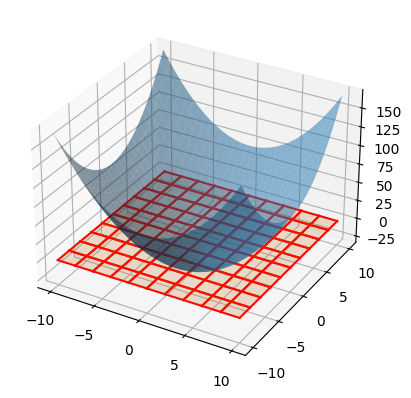

In [6]:
# # %matplotlib notebook
# import matplotlib.pyplot as plt
# import numpy as np
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.spatial import ConvexHull

# # Define 3D function
# def func(x, y):
#     return x**2 + y**2-30

# # Set up a 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for hypercube_id in range(hypercubes_edges.shape[1]):
#     # Define the rectangle corners
#     points = hypercubes_edges[:,hypercube_id,:]
#     hull = ConvexHull(points)
#     hull_points = points[hull.vertices]
#     rectangle_corners = np.append(hull_points, [hull_points[0]], axis=0)
#     # Plot rectangle
#     for i in range(len(rectangle_corners) - 1):
#         x = [rectangle_corners[i][0], rectangle_corners[i + 1][0]]
#         y = [rectangle_corners[i][1], rectangle_corners[i + 1][1]]
#         ax.plot(x, y, zs=0, color='r')  # zs=0 to plot on the xy-plane


# # Plot 3D function
# X = np.linspace(boundaries[0,0], boundaries[0,1], 30)
# Y = np.linspace(boundaries[1,0], boundaries[1,1], 30)
# X, Y = np.meshgrid(X, Y)
# Z = func(X, Y)
# z = np.zeros_like(X)
# ax.plot_surface(X, Y, Z, alpha=0.5) # alpha for transparency
# ax.plot_surface(X, Y, z, alpha=0.2) 

# # Show the plot
# plt.show()
